In [40]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import warnings
import datetime as dt
from IPython.core.display import display, HTML
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 200
from IPython.display import display, Markdown
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Reading in FCC wisp data
filepath = "../data/bb_data.csv"
wisp_df = pd.read_csv(filepath)

# Reading in population densities
filepath = "../data/us2016.csv"
pop_df = pd.read_csv(filepath)

In [9]:
# Pennsylvania population density
pa_pop_df = pop_df[pop_df['stateabbr'] == 'PA']
wisp_df = wisp_df[wisp_df['State'] == 'PA']

'''
Population information:

hu = housing units
hh = households
pop = population

'''
cols = ['stateabbr','block_fips','hu2016','hh2016','pop2016']
pa_pop_df = pa_pop_df[cols]

wisp_col_names = wisp_df.columns.values
wisp_rows = wisp_df.shape[0]
wisp_cols = wisp_df.shape[1]

Business Downstream Speeds: 


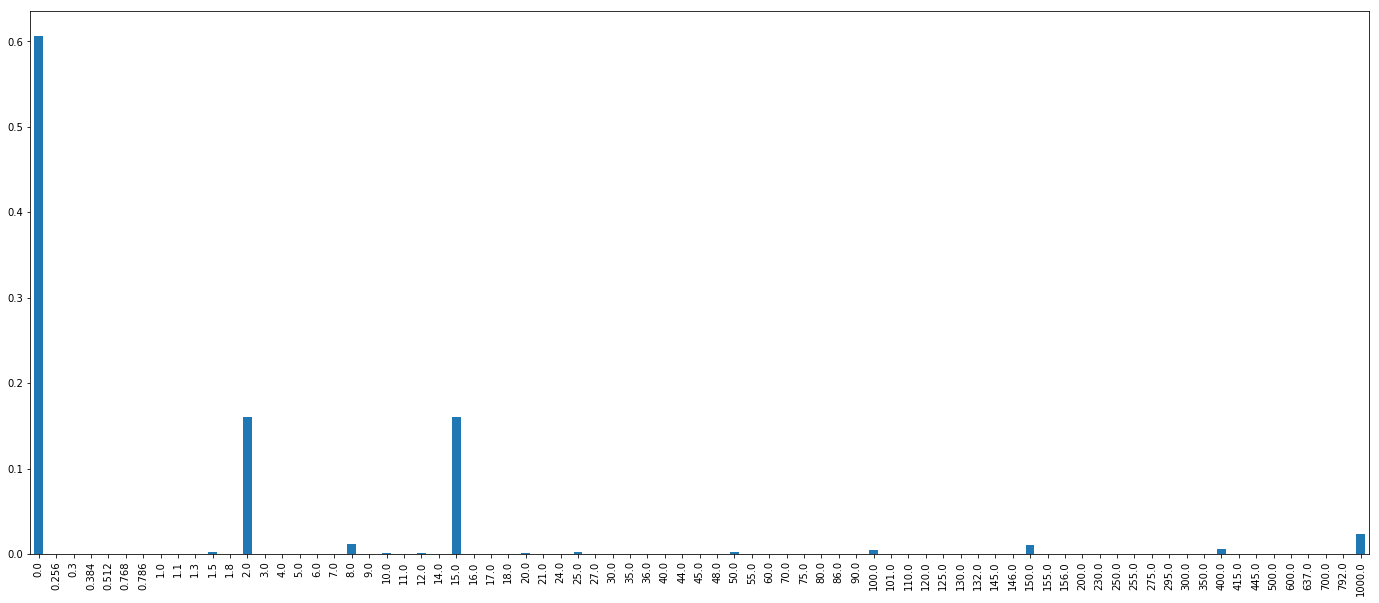

In [56]:
# What do up/down speeds look like for businesses in PA?
print('Business Downstream Speeds: ')
plt.figure(figsize=(24,10))
val_counts = wisp_df['Max CIR Downstream Speed (mbps)'][wisp_df['Business']==1].value_counts(normalize=True, sort = True).sort_index().plot(kind='bar')

#print('Business Upstream Speeds: ')
#print(wisp_df['Max CIR Upstream Speed (mbps)'][wisp_df['Business']==1].value_counts(normalize=True, sort = True, bins = 10))

In [ ]:
# What do up/down speeds look like for residential/commerical in PA?
wisp_df['Max Advertised Downstream Speed (mbps)'].value_counts(normalize=True)
wisp_df['Max Advertised Upstream Speed (mbps)'].value_counts(normalize=True)

# Wireless Internet Service Provider Research
## Intro
The goal of this project is to get an idea of the WISP landscape in Pennsylvania (specifically Mongtgomery County), and identify any untapped wireless markets, geographic or otherwise.

## A Warning from the FCC (IMPORTANT)
From the [explanation of FCC Data](https://www.fcc.gov/general/explanation-broadband-deployment-data):  A provider that reports deployment of a particular technology and bandwidth in a particular census block may not necessarily offer that particular service everywhere in the census block. Accordingly, a list of providers deployed in a census block does not necessarily reflect the number of choices available to any particular household or business location in that block, and the number of such providers in the census block does not purport to measure competition.

### My thoughts on this
The conclusions we draw here will have to be taken with a grain of salt, and will need to do additional research to verify and insights.

In [18]:
Markdown("""
## The Data
### WISP Data
The column names for the Wisp dataset are {wisp_col_names}. <br>
The table of PA WISP's has {wisp_rows} rows and {wisp_cols} columns.
""".format(wisp_col_names = wisp_col_names, wisp_rows = wisp_rows, wisp_cols = wisp_cols))


## The Data
### WISP Data
The column names for the Wisp dataset are ['Logical Record Number' 'Provider ID' 'FRN' 'Provider Name' 'DBA Name'
 'Holding Company Name' 'Holding Company Number' 'Holding Company Final'
 'State' 'Census Block FIPS Code' 'Technology Code' 'Consumer'
 'Max Advertised Downstream Speed (mbps)'
 'Max Advertised Upstream Speed (mbps)' 'Business'
 'Max CIR Downstream Speed (mbps)' 'Max CIR Upstream Speed (mbps)']. <br>
The table of PA WISP's has 2588294 rows and 17 columns.


## Filtering the WISPS

See the [explanation of FCC Data](https://www.fcc.gov/general/explanation-broadband-deployment-data) here for clarification on columns.

The function below filters the available list of wisps to be analyzed. Attributes on which to filter:
<br>
Max Advertised Upstream Speed (mbps) ** greater than or equal to 5**
<br>
Max Advertised Downstream Speed (mbps) ** greater than or equal to 25**
<br>
Max CIR Upstream Speed (mbps)  ** greater than or equal to 5**
<br>
Max CIR Downstream Speed (mbps)** greater than or equal to 25**
<br>
Business (Provider can or does offer business/government service in the block) **must be True**
<br>
Consumer (Provider can or does offer consumer/mass market/residential service in the block)  **currently not filtered**
<br>
### A Quick Note
From the [explanation of FCC Form 477 data](https://www.fcc.gov/general/explanation-broadband-deployment-data): Filer directed to report 0 if the contracted service is sold on a "best efforts" basis without a guaranteed data-throughput rate.  
<br>
Because of this, a wisp will be considered eligble for further analysis if its **Max Advertised or CIR up/downstream is greater than or equal to filter value**.

In [11]:
def filter_wisps(raw_df):
    start_t = dt.datetime.now()
    max_up = 5
    max_down = 25
    business = 1
    consumer = 1
    #state = 'PA'
    raw_df = raw_df[(raw_df['Max Advertised Upstream Speed (mbps)'] >= max_up) | (raw_df['Max CIR Upstream Speed (mbps)'] >= max_up) ]
    raw_df = raw_df[(raw_df['Max Advertised Downstream Speed (mbps)'] >= max_down) | (raw_df['Max CIR Downstream Speed (mbps)'] >= max_down)]
    raw_df = raw_df[(raw_df['Business'] == business)]
    #raw_df = raw_df[raw_df['State'] == state]
    final_t = dt.datetime.now()
    #print(f'took {final_t - start_t} to run!')
    return raw_df
pa_wisp_df = filter_wisps(wisp_df)
#pa_wisp_df.shape

took 0:00:00.304631 to run!


(560941, 17)

In [417]:
## wrtie PA files to csv's
pa_wisp_df.to_csv('../data/pa_bb.txt')
pa_pop_df.to_csv('../data/pa_pop.txt')

In [22]:
'''
Create Montgomery county subsets

PA state FIPS code 42
Montgomery county FIPS code 091
'''
pa_pop_df['block_fips']= pa_pop_df['block_fips'].apply(str)
pa_pop_df['mont_county'] = pa_pop_df['block_fips'].map(lambda x: True if x[:5] == '42091' else False)
mont_pop_df = pa_pop_df[pa_pop_df['mont_county']==True]

pa_wisp_df['Census Block FIPS Code'] = pa_wisp_df['Census Block FIPS Code'].apply(str)
pa_wisp_df['mont_county'] = pa_wisp_df['Census Block FIPS Code'].map(lambda x: True if x[:5] == '42091' else False)
mont_wisp_df = pa_wisp_df[pa_wisp_df['mont_county'] == True]

filtered_wisp_rows = pa_wisp_df.shape[0]
filtered_county_rows = mont_wisp_df.shape[0]

pa_blocks = pa_pop_df.shape[0]
mont_blocks = mont_pop_df.shape[0]


#print(f'number of blocks in montgomery county:  {mont_blocks}')
#print(f'number of eligble wisps in montgomery county:  {filtered_county_rows}')

number of blocks in montgomery county:  13769
number of eligble wisps in montgomery county:  26162


In [24]:
Markdown("""
## Filtered Results
After filtering, the total number of eligble wisps in PA is **{filtered_wisp_rows}**, down from {wisp_rows}, with {pa_blocks} census blocks in PA. <br>
After filtering, the number of eligible wisps in Montgomery County is **{filtered_county_rows}**, and there are {mont_blocks} census blocks in Montgomery County.
""".format(filtered_wisp_rows = filtered_wisp_rows, wisp_rows = wisp_rows, pa_blocks = pa_blocks, filtered_county_rows = filtered_county_rows, mont_blocks = mont_blocks))


## Filtered Results
After filtering, the total number of eligble wisps in PA is **560941**, down from 2588294, with 421545 census blocks in PA. <br>
After filtering, the number of eligible wisps in Montgomery County is **26162**, and there are 13769 census blocks in Montgomery County.


In [433]:
# Using the groubpy function to get metrics for each census block: count, types, mean up/down speeds
def get_metrics(raw_df):
    
    # A count of all the unique WISP's in a given census block,  if block isn't included in dataframe, then there are no WISPs in that block
    wisp_count_df = pd.DataFrame({'wisp_count':raw_df.groupby(['Census Block FIPS Code']).size()}).reset_index()
    wisp_count_df.set_index('Census Block FIPS Code', inplace=True)

    # Number of WISPs allowed to serve consumers in the given block
    consumer_df = pd.DataFrame({'consumer_num':raw_df.groupby(['Census Block FIPS Code','Consumer']).size()}).reset_index()
    consumer_df = consumer_df[consumer_df['Consumer']==1]
    consumer_df.set_index('Census Block FIPS Code', inplace=True)

    # Number of WISPs allowed to serve businesses in the given block
    business_df = pd.DataFrame({'business_num':raw_df.groupby(['Census Block FIPS Code', 'Business']).size()}).reset_index()
    business_df = business_df[business_df['Business']==1]
    business_df.set_index('Census Block FIPS Code', inplace = True)

    # Average up/downstream speeds in each census block
    adv_max_down_df = pd.DataFrame({'adv_max_down':raw_df.groupby(['Census Block FIPS Code'])['Max Advertised Downstream Speed (mbps)'].max()}).reset_index()
    adv_max_down_df.set_index('Census Block FIPS Code', inplace = True)
    
    adv_max_up_df = pd.DataFrame({'adv_max_up':raw_df.groupby(['Census Block FIPS Code'])['Max Advertised Upstream Speed (mbps)'].max()}).reset_index()
    adv_max_up_df.set_index('Census Block FIPS Code', inplace = True)
    
    cir_max_up_df = pd.DataFrame({'cir_max_up':raw_df.groupby(['Census Block FIPS Code'])['Max CIR Upstream Speed (mbps)'].max()}).reset_index()
    cir_max_up_df.set_index('Census Block FIPS Code', inplace = True)
    
    cir_max_down_df = pd.DataFrame({'cir_max_down':raw_df.groupby(['Census Block FIPS Code'])['Max CIR Downstream Speed (mbps)'].max()}).reset_index()
    cir_max_down_df.set_index('Census Block FIPS Code', inplace = True)
    
    #TODO: Merge the 7 df's
    df_list = [wisp_count_df,consumer_df,business_df,adv_max_down_df,adv_max_up_df,cir_max_up_df,cir_max_down_df]
    print('Merging dataframes...')
    for i in df_list:
        if wisp_count_df.equals(i):
            final_df = wisp_count_df
        else:
            final_df = pd.merge(final_df,i,how='outer',left_index=True, right_index=True)
    print('Done merging dataframes!')
    final_df.drop(['Consumer', 'Business'], axis = 1, inplace = True)
    return final_df 

In [434]:
# Get metrics for montgomery county
mont_metrics_df = get_metrics(mont_wisp_df)

# Get metrics for all of PA
pa_metrics_df = get_metrics(pa_wisp_df)

Merging dataframes...
Done merging dataframes!
Merging dataframes...
Done merging dataframes!


In [435]:
# Merging population data and WISP metrics
def merge_pop_wisp(pop_df,wisp_df):
    if (pop_df.index.name != 'block_fips'):
        pop_df.set_index('block_fips',inplace = True)
    final_df = pd.merge(pop_df, wisp_df,how = 'left', left_index = True, right_index = True)
    final_df.fillna(value = 0, inplace = True)
    final_df['density'] = final_df['wisp_count']/ (final_df['pop2016'] + 1)
    final_df.reset_index(inplace = True)
    final_df['best_available_up'] = final_df[['cir_max_up','adv_max_up']].max(axis = 1)
    final_df['best_available_down'] = final_df[['cir_max_down','adv_max_down']].max(axis = 1)
    return final_df 

In [436]:
# Merging metrics with population data
county_df = merge_pop_wisp(mont_pop_df, mont_metrics_df)
state_df = merge_pop_wisp(pa_pop_df, pa_metrics_df)

In [432]:
# Write county and state data to csv
county_df.to_csv('../data/montgomery_wisp_metrics.txt')
state_df.to_csv('../data/pa_wisp_metrics.txt')

## Baseline statistics

What are the important measures we want to see?

Breakdown of # wisps
Density map (wisp/population) in a given block
Heatmap of number of wisps operating in given census block (filter by type, up/down speed)
Correlation between WISP/population

In [443]:
# Wisp metrics by block
mont_met = county_df['wisp_count'].describe()
pa_met = state_df['wisp_count'].describe()

print(f'Basic wisp metrics by block in montogmery county: \n{mont_met}')
print(f'Basic wisp metrics by block in PA: \n{pa_met}')

Basic metrics of wisps in montogmery county: 
count    13769.000000
mean         1.900065
std          0.992289
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         12.000000
Name: wisp_count, dtype: float64
Basic metrics of wisps in PA: 
count    421545.000000
mean          1.330679
std           1.244162
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          16.000000
Name: wisp_count, dtype: float64


In [445]:
pa_value_counts = state_df['wisp_count'].value_counts(normalize = True)
print(f'Number of eligble wisps operating in each block: \n{pa_value_counts}')

Number of wisps operating in each block: 
0.0     0.319297
1.0     0.281114
2.0     0.222961
3.0     0.118768
4.0     0.044377
5.0     0.011842
6.0     0.001229
7.0     0.000244
8.0     0.000081
9.0     0.000045
10.0    0.000021
12.0    0.000009
13.0    0.000005
16.0    0.000002
11.0    0.000002
14.0    0.000002
Name: wisp_count, dtype: float64
